In [1]:
import numpy as np
import pandas as pd
import gc
import os
import matplotlib.pyplot as plt
import polars as pl
from sklearn.metrics import mean_squared_error, mean_absolute_error
from joblib import Parallel, delayed
from more_itertools import chunked
from functools import reduce
from typing import List
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import pandas as pd
import joblib
import os


El objetivo de este Notebook es preparar los datos para modelar con redes neuronales

In [2]:
# Reducir memoria automáticamente
def optimizar_memoria(df):
    for col in df.select_dtypes(include=['int64', 'int32']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    for col in df.select_dtypes(include=['float64', 'float32']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    return df

In [3]:
# Abrir el archivo parquet y cargarlo en un DataFrame data/l_vm_completa_train_pendientes.parquet
gc.collect()
df_full = pd.read_parquet('./data/l_vm_completa_train.parquet', engine='fastparquet')

In [4]:
# Eliminar de df_agrupado las filas donde la columna A_PREDECIR sea 'N'
df_full = df_full[df_full['A_PREDECIR'] != 'N']
df_full = df_full.drop(columns=['A_PREDECIR'])

In [5]:
df_agrupado = (
    df_full.groupby([
        'ORDINAL','PERIODO', 'ANIO', 'MES', 'MES_SIN', 'MES_COS', 'TRIMESTRE',
        'ID_CAT1', 'ID_CAT2', 'ID_CAT3', 'ID_BRAND', 'SKU_SIZE', 'PRODUCT_ID'
    ], as_index=False)[['TN', 'CLASE']].sum()
)

In [6]:
del df_full
gc.collect()

20

In [7]:
# Mostrar las filas de df_agrupado ordernadas por TN de menor a mayor
df_agrupado = df_agrupado.sort_values(by='TN', ascending=True)
# Mostrar las primeras 10 filas de df_agrupado
print(df_agrupado.head(10))

       ORDINAL  PERIODO  ANIO  MES   MES_SIN   MES_COS  TRIMESTRE  ID_CAT1  \
1651         4   201704  2017    4  0.866025 -0.500000          2        2   
15419       27   201903  2019    3  1.000000  0.000000          1        3   
15420       27   201903  2019    3  1.000000  0.000000          1        3   
13231       24   201812  2018   12  0.000000  1.000000          4        3   
9774        18   201806  2018    6  0.000000 -1.000000          2        3   
11922       22   201810  2018   10 -0.866025  0.500000          4        3   
10438       20   201808  2018    8 -0.866025 -0.500000          3        1   
10616       20   201808  2018    8 -0.866025 -0.500000          3        2   
16359       29   201905  2019    5  0.500000 -0.866025          2        1   
1944         4   201704  2017    4  0.866025 -0.500000          2        3   

       ID_CAT2  ID_CAT3  ID_BRAND  SKU_SIZE  PRODUCT_ID   TN      CLASE  
1651         9       26        24      3000       20313  0.0    7.9

In [8]:
# Agregar a df_full una variable categorica MES_PROBLEMATICO que sea 1 si PERIODO es 201906 o 201908 o 201910, y 0 en caso contrario
# Calcular los días del mes usando las columnas ANIO y MES

# Agregar a df_full una variable categorica MES_PROBLEMATICO que sea 1 si ANIO==2019 y MES en [6, 8, 10], y 0 en caso contrario
df_agrupado['MES_PROBLEMATICO'] = np.where(
       (df_agrupado['ANIO'] == 2019) & (df_agrupado['MES'].isin([6, 8, 10])),
       1., 0.0
)
df_agrupado['MES_PROBLEMATICO'] = df_agrupado['MES_PROBLEMATICO'].astype(np.float32)

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from joblib import Parallel, delayed

ROLL_BASE = 12
CAIDA_UMBRAL = -100

def add_global_features(group):
    group = group.sort_values('PERIODO').copy()
    group['FECHA'] = pd.to_datetime(group['PERIODO'].astype(str), format='%Y%m')
    group['MES'] = group['FECHA'].dt.month
    group['IS_FEBRERO'] = (group['MES'] == 2).astype(int)
    group['ESTOY_PREDICIENDO_FEBRERO'] = (group['MES'] == 12).astype(int)
    
    max_global = group['TN'].max()
    group['TN_MAX_GLOBAL'] = max_global
    group['TN_DIST_A_MAX'] = max_global - group['TN']
    group['TN_RATIO_VS_MAX'] = group['TN'] / (max_global + 1e-8)

    roll_mean = group['TN'].rolling(ROLL_BASE, min_periods=3)
    group['TN_MEAN_12'] = roll_mean.mean()
    group['TN_STD_12'] = roll_mean.std()
    group['TN_COEF_VAR_12'] = group['TN_STD_12'] / (group['TN_MEAN_12'] + 1e-8)

    group['TN_DIFF_T_1'] = group['TN'].diff(1)
    group['TN_DIFF_T_2'] = group['TN'].diff(2)
    group['CAIDA_ABRUPTA'] = (group['TN_DIFF_T_1'] < CAIDA_UMBRAL).astype(int)

    feb_mask = group['MES'] == 2
    group['TN_EN_FEBREROS_ANTERIORES'] = (
        group.loc[feb_mask, 'TN']
        .expanding()
        .mean()
        .shift(1)
        .reindex(group.index, fill_value=0)
    )

    group['PROMEDIO_MES'] = (
        group.groupby(['PRODUCT_ID', 'MES'])['TN']
        .transform(lambda x: x.shift().expanding().mean())
        .fillna(0)
    )

    def ultimos_3_feb(sub):
        feb = sub[sub['MES'] == 2]
        ultimos = feb.tail(3)
        media = ultimos['TN'].mean() if len(ultimos) > 0 else 0
        sub['TN_EN_FEBREROS_ULT_3'] = media
        return sub

    group = group.groupby('PRODUCT_ID', group_keys=False).apply(ultimos_3_feb)
    group.fillna(0, inplace=True)
    return group

def calcular_pendientes_grupo(group, periodos_list):
    group = add_global_features(group)
    group = group.sort_values(by='PERIODO').copy()
    n = len(group)
    y_values = group['TN'].values
    for cant in periodos_list:
        means = np.zeros(n)
        pendientes = np.zeros(n)
        ewmas = np.zeros(n)
        medians = np.zeros(n)
        minimo = np.zeros(n)
        maximo = np.zeros(n)
        stds = np.zeros(n)
        skews = np.zeros(n)
        kurts = np.zeros(n)
        growths = np.zeros(n)
        iqrs = np.zeros(n)
        sums = np.zeros(n)
        count_pos = np.zeros(n)
        pct_zero = np.zeros(n)
        last = np.zeros(n)
        last_diff = np.zeros(n)

        coef_var = np.zeros(n)
        maxmin_ratio = np.zeros(n)
        rango = np.zeros(n)
        rango_rel = np.zeros(n)
        last_vs_median = np.zeros(n)
        cambio_ventana = np.zeros(n)
        zeros_end = np.zeros(n)
        last_pct_sum = np.zeros(n)
        pct_90 = np.zeros(n)
        pct_10 = np.zeros(n)
        pct_width = np.zeros(n)

        # --- Comparaciones TN vs rolling stats ---
        tn_minus_mean = np.zeros(n)
        tn_minus_median = np.zeros(n)
        tn_minus_ewma = np.zeros(n)
        tn_over_mean = np.zeros(n)
        tn_over_median = np.zeros(n)
        tn_over_ewma = np.zeros(n)

        x = np.arange(cant)
        for i in range(n):
            # Solo procesar si la ventana está completa
            if i >= cant - 1:
                y = y_values[i - (cant - 1): i + 1]
                means[i] = np.mean(y)
                try:
                    pendientes[i] = np.polyfit(x, y, 1)[0]
                except:
                    pendientes[i] = 0
                ewmas[i] = pd.Series(y).ewm(span=cant, adjust=False).mean().iloc[-1]
                medians[i] = np.median(y)
                minimo[i] = np.min(y)
                maximo[i] = np.max(y)
                std_y = np.std(y)
                mean_y = means[i]
                stds[i] = std_y
                skews[i] = skew(y) if std_y > 0 else 0
                kurts[i] = kurtosis(y) if std_y > 0 else 0
                growths[i] = (y[-1] - y[0]) / (y[0] + 1e-8) if y[0] != 0 else 0
                iqrs[i] = np.percentile(y, 75) - np.percentile(y, 25)
                sums[i] = np.sum(y)
                count_pos[i] = np.sum(y > 0)
                pct_zero[i] = np.mean(y == 0)
                last[i] = y[-1]
                last_diff[i] = y[-1] - y[-2] if cant > 1 else 0

                coef_var[i] = std_y / (mean_y + 1e-8) if mean_y != 0 else 0
                maxmin_ratio[i] = maximo[i] / (minimo[i] + 1e-8) if minimo[i] != 0 else 0
                rango[i] = maximo[i] - minimo[i]
                rango_rel[i] = rango[i] / (minimo[i] + 1e-8) if minimo[i] != 0 else 0
                last_vs_median[i] = y[-1] - np.median(y)
                # Cambio de ventana anterior a actual
                if i >= 2 * cant - 1:
                    y_prev = y_values[i - (2 * cant - 1):i - cant + 1]
                    mean_prev = np.mean(y_prev)
                    cambio_ventana[i] = (mean_y - mean_prev) / (mean_prev + 1e-8) if mean_prev != 0 else 0
                zeros_end[i] = np.argmax(y[::-1] != 0)
                last_pct_sum[i] = y[-1] / (np.sum(y) + 1e-8) if np.sum(y) != 0 else 0
                pct_90[i] = np.percentile(y, 90)
                pct_10[i] = np.percentile(y, 10)
                pct_width[i] = pct_90[i] - pct_10[i]

                # Comparaciones TN vs rolling stats
                tn_actual = y_values[i]
                tn_minus_mean[i] = tn_actual - means[i]
                tn_minus_median[i] = tn_actual - medians[i]
                tn_minus_ewma[i] = tn_actual - ewmas[i]
                tn_over_mean[i] = tn_actual / (means[i] + 1e-8) if means[i] != 0 else 0
                tn_over_median[i] = tn_actual / (medians[i] + 1e-8) if medians[i] != 0 else 0
                tn_over_ewma[i] = tn_actual / (ewmas[i] + 1e-8) if ewmas[i] != 0 else 0
            # Si la ventana no está completa, todo queda en cero (ya inicializado)

        group[f'TN_MEAN_{str(cant).zfill(2)}'] = means
        group[f'PENDIENTE_TENDENCIA_{cant}'] = pendientes
        group[f'TN_EWMA_{str(cant).zfill(2)}'] = ewmas
        group[f'TN_MEDIAN_{str(cant).zfill(2)}'] = medians
        group[f'TN_MIN_{str(cant).zfill(2)}'] = minimo
        group[f'TN_MAX_{str(cant).zfill(2)}'] = maximo
        group[f'TN_STD_{str(cant).zfill(2)}'] = stds
        group[f'TN_SKEW_{str(cant).zfill(2)}'] = skews
        group[f'TN_KURT_{str(cant).zfill(2)}'] = kurts
        group[f'TN_GROWTH_{str(cant).zfill(2)}'] = growths
        group[f'TN_IQR_{str(cant).zfill(2)}'] = iqrs
        group[f'TN_SUM_{str(cant).zfill(2)}'] = sums
        group[f'TN_COUNT_POS_{str(cant).zfill(2)}'] = count_pos
        group[f'TN_PCT_ZERO_{str(cant).zfill(2)}'] = pct_zero
        group[f'TN_LAST_{str(cant).zfill(2)}'] = last
        group[f'TN_LAST_DIFF_{str(cant).zfill(2)}'] = last_diff

        group[f'TN_COEF_VAR_{cant}'] = coef_var
        group[f'TN_MAXMIN_RATIO_{cant}'] = maxmin_ratio
        group[f'TN_RANGO_{cant}'] = rango
        group[f'TN_RANGO_REL_{cant}'] = rango_rel
        group[f'TN_LAST_VS_MEDIAN_{cant}'] = last_vs_median
        group[f'TN_CHANGE_PREV_WINDOW_{cant}'] = cambio_ventana
        group[f'TN_ZEROS_END_{cant}'] = zeros_end
        group[f'TN_LAST_PCT_SUM_{cant}'] = last_pct_sum
        group[f'TN_PCT90_{cant}'] = pct_90
        group[f'TN_PCT10_{cant}'] = pct_10
        group[f'TN_PCT_WIDTH_{cant}'] = pct_width

        # Comparaciones TN vs rolling stats
        group[f'TN_MINUS_MEAN_{str(cant).zfill(2)}'] = tn_minus_mean
        group[f'TN_MINUS_MEDIAN_{str(cant).zfill(2)}'] = tn_minus_median
        group[f'TN_MINUS_EWMA_{str(cant).zfill(2)}'] = tn_minus_ewma
        group[f'TN_OVER_MEAN_{str(cant).zfill(2)}'] = tn_over_mean
        group[f'TN_OVER_MEDIAN_{str(cant).zfill(2)}'] = tn_over_median
        group[f'TN_OVER_EWMA_{str(cant).zfill(2)}'] = tn_over_ewma

    return group

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from joblib import Parallel, delayed

def calcular_pendientes_parallel(df, periodos_list=[6, 12], n_jobs=20):
    group_cols = [col for col in df.columns if col != 'TN']
    print("Agrupando por columnas:", group_cols)
    grupos = [group for _, group in df.groupby(group_cols)]
    resultados = Parallel(n_jobs=n_jobs, backend='loky', verbose=10)(
        delayed(calcular_pendientes_grupo)(group, periodos_list) for group in grupos
    )
    df_final = pd.concat(resultados, ignore_index=True)
    df_final.replace([np.inf, -np.inf], 0, inplace=True)
    df_final.fillna(0, inplace=True)
    return df_final

# --- Script principal ---
df_agrupado = calcular_pendientes_parallel(df_agrupado, periodos_list=[3, 6, 9, 12, 18], n_jobs=28)

In [10]:
import pandas as pd

# Asumo que ya tenés df_agrupado y las columnas que vas a usar existen
lags = [3, 6, 9, 12, 18]

# Definí la columna de agrupamiento, por ejemplo:
group_cols = ['PRODUCT_ID']  # Cambia esto si tu agrupamiento es por otra cosa

# Ordenar el DataFrame por las claves necesarias
df_agrupado = df_agrupado.sort_values(group_cols + ['ORDINAL'], ascending=[True, False])

for lag in lags:
    lag_col = f'TN_LAG_{lag:02d}'
    delta_col = f'TN_DELTA_{lag:02d}'
    # Calcular el lag
    df_agrupado[lag_col] = (
        df_agrupado.groupby(group_cols)['TN']
        .shift(-lag)  # Sentido descendente en ORDINAL
        .fillna(0)
    )
    # Calcular el delta
    df_agrupado[delta_col] = df_agrupado['TN'] - df_agrupado[lag_col]

# Si querés, podés ver las primeras filas
print(df_agrupado[[f'TN_LAG_{l:02d}' for l in lags] + [f'TN_DELTA_{l:02d}' for l in lags]].head())


        TN_LAG_03   TN_LAG_06   TN_LAG_09   TN_LAG_12   TN_LAG_18  \
21844  1660.00561  1109.93769  1470.65653  1486.68669  1150.79169   
21064  1261.34529  1629.78233  1259.09363  1813.01511  1293.89788   
20284  1678.99318  1647.63848  1275.77351  2295.19832  1251.28462   
19504  1109.93769  1470.65653  1486.68669  1438.67455  1856.83534   
18730  1629.78233  1259.09363  1813.01511  1800.96168  1043.76470   

       TN_DELTA_03  TN_DELTA_06  TN_DELTA_09  TN_DELTA_12  TN_DELTA_18  
21844   -155.31705    394.75087     34.03203     18.00187    353.89687  
21064    136.02702   -232.41002    138.27868   -415.64280    103.47443  
20284   -117.48766    -86.13296    285.73201   -733.69280    310.22090  
19504    550.06792    189.34908    173.31892    221.33106   -196.82973  
18730   -368.43704      2.25166   -551.66982   -539.61639    217.58059  


In [11]:
import numpy as np
import pandas as pd

windows = [3, 6, 9, 12, 18]
group_cols = ['PRODUCT_ID']  # agregá más claves si corresponde

for w in windows:
    # CRECIMIENTO PERCENTUAL (respecto al lag de la ventana)
    lag_col = f'TN_LAG_{w:02d}'
    growth_col = f'TN_GROWTH_{w:02d}'
    if lag_col in df_agrupado.columns:
        df_agrupado[growth_col] = (df_agrupado['TN'] - df_agrupado[lag_col]) / (df_agrupado[lag_col].replace(0, np.nan))
        df_agrupado[growth_col] = df_agrupado[growth_col].fillna(0)
    
    # CANTIDAD DE CEROS EN LA VENTANA
    count_zero_col = f'TN_COUNT_ZERO_{w:02d}'
    df_agrupado[count_zero_col] = (
        df_agrupado
        .groupby(group_cols)['TN']
        .rolling(window=w, min_periods=1)
        .apply(lambda x: np.sum(x == 0), raw=True)
        .reset_index(level=0, drop=True)
    )
    
    # NÚMERO DE CAMBIOS DE SIGNO EN LA VENTANA
    sign_change_col = f'TN_SIGN_CHANGES_{w:02d}'
    df_agrupado[sign_change_col] = (
        df_agrupado
        .groupby(group_cols)['TN']
        .rolling(window=w, min_periods=2)
        .apply(lambda x: np.sum(np.diff(np.sign(x)) != 0), raw=True)
        .reset_index(level=0, drop=True)
    )
    
    # COEFICIENTE DE VARIACIÓN EN LA VENTANA
    coef_var_col = f'TN_COEF_VAR_{w:02d}'
    mean_col = f'TN_MEAN_{w:02d}'
    std_col = f'TN_STD_{w:02d}'
    # Si ya tenés mean y std, sólo calculás la división, si no, calculás aquí
    if mean_col in df_agrupado.columns and std_col in df_agrupado.columns:
        df_agrupado[coef_var_col] = df_agrupado[std_col] / (df_agrupado[mean_col].replace(0, np.nan))
        df_agrupado[coef_var_col] = df_agrupado[coef_var_col].fillna(0)
    else:
        df_agrupado[mean_col] = (
            df_agrupado.groupby(group_cols)['TN']
            .rolling(window=w, min_periods=1).mean()
            .reset_index(level=0, drop=True)
        )
        df_agrupado[std_col] = (
            df_agrupado.groupby(group_cols)['TN']
            .rolling(window=w, min_periods=1).std().fillna(0)
            .reset_index(level=0, drop=True)
        )
        df_agrupado[coef_var_col] = df_agrupado[std_col] / (df_agrupado[mean_col].replace(0, np.nan))
        df_agrupado[coef_var_col] = df_agrupado[coef_var_col].fillna(0)
    
    # PROPORCIÓN DE OUTLIERS (> 2 * std en la ventana)
    outlier_col = f'TN_OUTLIER_PROP_{w:02d}'
    def outlier_prop(x):
        m = np.nanmean(x)
        s = np.nanstd(x)
        if s == 0:
            return 0
        return np.mean(np.abs(x - m) > 2 * s)
    df_agrupado[outlier_col] = (
        df_agrupado
        .groupby(group_cols)['TN']
        .rolling(window=w, min_periods=2)
        .apply(outlier_prop, raw=True)
        .reset_index(level=0, drop=True)
    )

    # PROPORCIÓN DE VENTAS MAYORES A CERO
    pct_pos_col = f'TN_PCT_POS_{w:02d}'
    df_agrupado[pct_pos_col] = (
        df_agrupado
        .groupby(group_cols)['TN']
        .rolling(window=w, min_periods=1)
        .apply(lambda x: np.mean(x > 0), raw=True)
        .reset_index(level=0, drop=True)
    )

# Si querés ver un resumen de las nuevas columnas:
cols_new = [
    f'TN_GROWTH_{w:02d}' for w in windows
] + [
    f'TN_COUNT_ZERO_{w:02d}' for w in windows
] + [
    f'TN_SIGN_CHANGES_{w:02d}' for w in windows
] + [
    f'TN_COEF_VAR_{w:02d}' for w in windows
] + [
    f'TN_OUTLIER_PROP_{w:02d}' for w in windows
] + [
    f'TN_PCT_POS_{w:02d}' for w in windows
]
print(df_agrupado[cols_new].head())

       TN_GROWTH_03  TN_GROWTH_06  TN_GROWTH_09  TN_GROWTH_12  TN_GROWTH_18  \
21844     -0.093564      0.355651      0.023141      0.012109      0.307525   
21064      0.107843     -0.142602      0.109824     -0.229255      0.079971   
20284     -0.069975     -0.052277      0.223968     -0.319664      0.247922   
19504      0.495585      0.128751      0.116581      0.153844     -0.106003   
18730     -0.226065      0.001788     -0.304283     -0.299627      0.208458   

       TN_COUNT_ZERO_03  TN_COUNT_ZERO_06  TN_COUNT_ZERO_09  TN_COUNT_ZERO_12  \
21844               0.0               0.0               0.0               0.0   
21064               0.0               0.0               0.0               0.0   
20284               0.0               0.0               0.0               0.0   
19504               0.0               0.0               0.0               0.0   
18730               0.0               0.0               0.0               0.0   

       TN_COUNT_ZERO_18  ...  TN_OUTLI

In [12]:
print(df_agrupado.columns.tolist())

['ORDINAL', 'PERIODO', 'ANIO', 'MES', 'MES_SIN', 'MES_COS', 'TRIMESTRE', 'ID_CAT1', 'ID_CAT2', 'ID_CAT3', 'ID_BRAND', 'SKU_SIZE', 'PRODUCT_ID', 'TN', 'CLASE', 'MES_PROBLEMATICO', 'TN_MEAN_03', 'PENDIENTE_TENDENCIA_3', 'TN_EWMA_03', 'TN_MEDIAN_03', 'TN_MIN_03', 'TN_MAX_03', 'TN_STD_03', 'TN_SKEW_03', 'TN_KURT_03', 'TN_GROWTH_03', 'TN_IQR_03', 'TN_SUM_03', 'TN_COUNT_POS_03', 'TN_PCT_ZERO_03', 'TN_LAST_03', 'TN_LAST_DIFF_03', 'TN_COEF_VAR_3', 'TN_MAXMIN_RATIO_3', 'TN_RANGO_3', 'TN_RANGO_REL_3', 'TN_LAST_VS_MEDIAN_3', 'TN_CHANGE_PREV_WINDOW_3', 'TN_ZEROS_END_3', 'TN_LAST_PCT_SUM_3', 'TN_PCT90_3', 'TN_PCT10_3', 'TN_PCT_WIDTH_3', 'TN_MINUS_MEAN_03', 'TN_MINUS_MEDIAN_03', 'TN_MINUS_EWMA_03', 'TN_OVER_MEAN_03', 'TN_OVER_MEDIAN_03', 'TN_OVER_EWMA_03', 'TN_MEAN_06', 'PENDIENTE_TENDENCIA_6', 'TN_EWMA_06', 'TN_MEDIAN_06', 'TN_MIN_06', 'TN_MAX_06', 'TN_STD_06', 'TN_SKEW_06', 'TN_KURT_06', 'TN_GROWTH_06', 'TN_IQR_06', 'TN_SUM_06', 'TN_COUNT_POS_06', 'TN_PCT_ZERO_06', 'TN_LAST_06', 'TN_LAST_DIFF_06',

Estadísticas básicas de CLASE:
count    22375.000000
mean        47.261061
std        123.097039
min          0.000000
25%          2.041395
50%         10.062170
75%         32.214200
max       2295.198320
Name: CLASE, dtype: float64

Primeros valores únicos (si son pocos): [   0.      1504.68856 1397.37231 1561.50552 1659.9384  1261.34529
 1678.86996 1109.91529 1629.78233 1647.45925]
Cantidad de valores únicos: 20638

Cantidad de nulos: 0


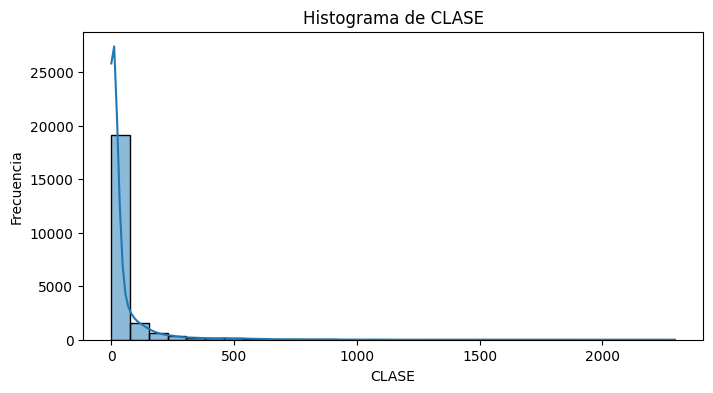

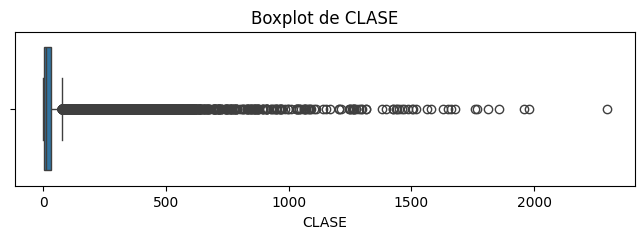

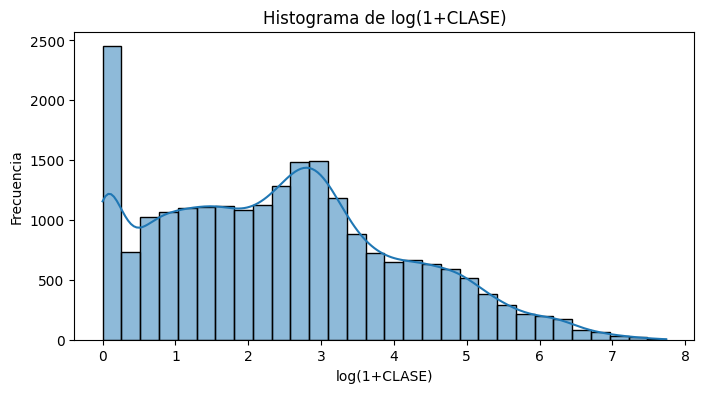


Percentiles de CLASE:
0.00       0.000000
0.01       0.000000
0.05       0.000000
0.25       2.041395
0.50      10.062170
0.75      32.214200
0.95     217.743778
0.99     605.542223
1.00    2295.198320
Name: CLASE, dtype: float64

Cantidad de outliers (>3 desvíos): 502


/tmp/ipykernel_5102/606330473.py:50: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='PERIODO', y='CLASE', data=df_agrupado, ci=None)


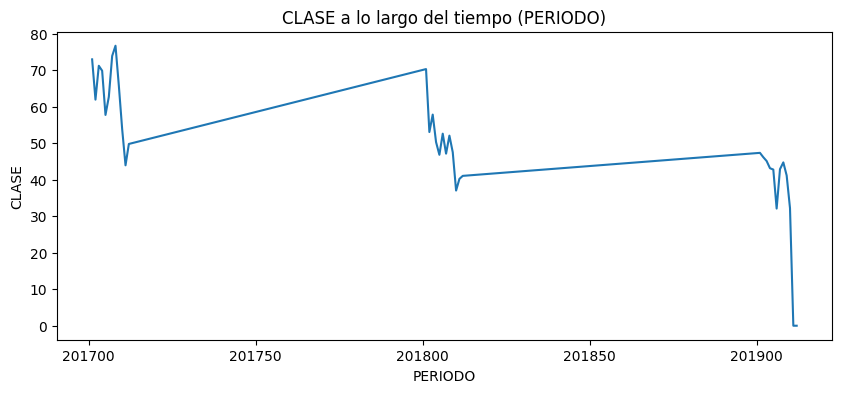

In [13]:
# Hacer un EDA de la columna  CLASE en  df_agrupado
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Estadísticas descriptivas ---
print("Estadísticas básicas de CLASE:")
print(df_agrupado['CLASE'].describe())

print("\nPrimeros valores únicos (si son pocos):", df_agrupado['CLASE'].unique()[:10])
print("Cantidad de valores únicos:", df_agrupado['CLASE'].nunique())

print("\nCantidad de nulos:", df_agrupado['CLASE'].isna().sum())

# --- Histograma ---
plt.figure(figsize=(8,4))
sns.histplot(df_agrupado['CLASE'], bins=30, kde=True)
plt.title("Histograma de CLASE")
plt.xlabel("CLASE")
plt.ylabel("Frecuencia")
plt.show()

# --- Boxplot para ver outliers ---
plt.figure(figsize=(8,2))
sns.boxplot(x=df_agrupado['CLASE'])
plt.title("Boxplot de CLASE")
plt.show()

# --- Distribución log-transformada (útil si hay muchos valores chicos y pocos grandes) ---
plt.figure(figsize=(8,4))
sns.histplot(np.log1p(df_agrupado['CLASE']), bins=30, kde=True)
plt.title("Histograma de log(1+CLASE)")
plt.xlabel("log(1+CLASE)")
plt.ylabel("Frecuencia")
plt.show()

# --- Percentiles y cuantiles ---
print("\nPercentiles de CLASE:")
print(df_agrupado['CLASE'].quantile([0, 0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99, 1]))

# --- Outliers extremos (más allá de 3 desviaciones estándar) ---
media = df_agrupado['CLASE'].mean()
std = df_agrupado['CLASE'].std()
outliers = df_agrupado[(df_agrupado['CLASE'] > media + 3*std) | (df_agrupado['CLASE'] < media - 3*std)]
print(f"\nCantidad de outliers (>3 desvíos): {len(outliers)}")

# --- Relación con otras variables (ejemplo: PERIODO) ---
if 'PERIODO' in df_agrupado.columns:
    plt.figure(figsize=(10,4))
    sns.lineplot(x='PERIODO', y='CLASE', data=df_agrupado, ci=None)
    plt.title("CLASE a lo largo del tiempo (PERIODO)")
    plt.show()




In [14]:
df_agrupado['CLASE_LOG1P'] = np.log1p(df_agrupado['CLASE'])
# Y para invertir:
#df_agrupado['CLASE'] = np.expm1(df_full['CLASE_LOG1P'])

# Eliminar la columna CLASE 
df_agrupado = df_agrupado.drop(columns=['CLASE'])


In [15]:
from sklearn.preprocessing import StandardScaler

# FIT scaler solo sobre entrenamiento
mask_train = df_agrupado['PERIODO'] <= 201909
scaler_y = StandardScaler()
scaler_y.fit(df_agrupado.loc[mask_train, ['CLASE_LOG1P']])

# Aplicar la transformación a todo df_full
df_agrupado['CLASE_LOG1P_Z'] = scaler_y.transform(df_agrupado[['CLASE_LOG1P']])

# Guardar media y std
media_y = scaler_y.mean_[0]
std_y = scaler_y.scale_[0]
print(f"Media usada (entrenamiento): {media_y}")
print(f"Std usada (entrenamiento): {std_y}")


Media usada (entrenamiento): 2.6464662550078493
Std usada (entrenamiento): 1.5637025287272237


In [16]:
import joblib

# Guardar a disco
joblib.dump(scaler_y, 'scaler_y_CLASE_LOG1P.joblib')


['scaler_y_CLASE_LOG1P.joblib']

In [ ]:
import joblib

# Cargar desde disco
#scaler_y = joblib.load('scaler_y_CLASE_LOG1P.joblib')
#y_pred_log1p = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()



In [17]:
# Eliminar las columnas CLASE y CLASE_LOG1P para evitar confusiones
df_agrupado.drop(columns=['CLASE', 'CLASE_LOG1P'], inplace=True, errors='ignore')

In [ ]:
print(df_agrupado.columns.tolist())

In [18]:
# Guardar el DataFrame en parquet
df_agrupado.to_parquet('./data/product_interm_NN_TORCH.parquet', index=False, engine='fastparquet')

In [ ]:
df_agrupado = pd.read_parquet('./data/product_interm_NN_TORCH.parquet', index=False, engine='fastparquet')

In [20]:
# Excluir la variable de clase
cols_to_check = df_agrupado.columns.difference(['CLASE_LOG1P_Z'])

# Calcular cantidad de NaNs por columna
nan_columns = df_agrupado[cols_to_check].isna().sum()

# Filtrar solo las columnas que tienen al menos un NaN
nan_columns = nan_columns[nan_columns > 0].sort_values(ascending=False)

# Mostrar
print(nan_columns)

TN_OUTLIER_PROP_03    780
TN_OUTLIER_PROP_06    780
TN_OUTLIER_PROP_09    780
TN_OUTLIER_PROP_12    780
TN_OUTLIER_PROP_18    780
TN_SIGN_CHANGES_03    780
TN_SIGN_CHANGES_06    780
TN_SIGN_CHANGES_09    780
TN_SIGN_CHANGES_12    780
TN_SIGN_CHANGES_18    780
dtype: int64


In [22]:
cols_to_check = df_agrupado.columns.difference(['CLASE_LOG1P_Z'])

# Reemplaza NaN e infinitos por 0 solo en las columnas seleccionadas
df_agrupado[cols_to_check] = df_agrupado[cols_to_check].replace([np.nan, np.inf, -np.inf], 0)

# Excluir la variable de clase
cols_to_check = df_agrupado.columns.difference(['CLASE_LOG1P_Z'])

# Calcular cantidad de NaNs por columna
nan_columns = df_agrupado[cols_to_check].isna().sum()

# Filtrar solo las columnas que tienen al menos un NaN
nan_columns = nan_columns[nan_columns > 0].sort_values(ascending=False)

# Mostrar
print(nan_columns)

Series([], dtype: int64)


In [23]:
print(f"📊 DataFrame final con {df_agrupado.shape[0]:,} filas y {df_agrupado.shape[1]} columnas:")

📊 DataFrame final con 22,375 filas y 214 columnas:


In [24]:
# Copia de seguridad del DataFrame
df = df_agrupado.copy()

# === Binning (en deciles) ===
df['PRODUCT_RANK_BIN'] = pd.qcut(df['PRODUCT_ID'], q=10, labels=False)
df['PRODUCT_RANK_BIN'] = df['PRODUCT_RANK_BIN'].astype('category')

# Reemplazar en el DataFrame principal
df_agrupado = df


In [25]:
cat_cols = ['ID_CAT1', 'ID_CAT2', 'ID_CAT3', 'ID_BRAND', 'SKU_SIZE','MES_PROBLEMATICO','PRODUCT_RANK_BIN']

for col in cat_cols:
    if df_agrupado[col].isnull().any():
        df_agrupado[col] = df_agrupado[col].fillna("missing")


encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df_agrupado.loc[:, col] = le.fit_transform(df_agrupado[col]).astype(int)
    encoders[col] = le  # para guardar los mapeos por si necesitás revertirlos

# Guardo los encoders en archivos .pkl
import joblib
import os

os.makedirs('encoders', exist_ok=True)

for col, le in encoders.items():
    joblib.dump(le, f'encoders/{col}_encoder.pkl')

In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib
import os

# Copia del DataFrame original
df = df_agrupado.copy()

# 1. Columnas categóricas (auto si no existen)
if 'cat_cols' not in locals():
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
for col in ['PRODUCT_RANK_BIN']:
    if col not in cat_cols:
        cat_cols.append(col)

# 2. Columnas a excluir del escalado
excluir = ['PERIODO', 'CLASE_LOG1P_Z', 'MES_SIN', 'MES_COS'] + cat_cols
print("Columnas excluidas del escalado:", excluir)

# 3. Columnas numéricas a escalar
cols_a_escalar = [
    col for col in df.columns
    if col not in excluir and pd.api.types.is_numeric_dtype(df[col])
]
print("Columnas numéricas a escalar:", cols_a_escalar)


Columnas excluidas del escalado: ['PERIODO', 'CLASE_LOG1P_Z', 'MES_SIN', 'MES_COS', 'ID_CAT1', 'ID_CAT2', 'ID_CAT3', 'ID_BRAND', 'SKU_SIZE', 'MES_PROBLEMATICO', 'PRODUCT_RANK_BIN']
Columnas numéricas a escalar: ['ORDINAL', 'ANIO', 'MES', 'TRIMESTRE', 'PRODUCT_ID', 'TN', 'TN_MEAN_03', 'PENDIENTE_TENDENCIA_3', 'TN_EWMA_03', 'TN_MEDIAN_03', 'TN_MIN_03', 'TN_MAX_03', 'TN_STD_03', 'TN_SKEW_03', 'TN_KURT_03', 'TN_GROWTH_03', 'TN_IQR_03', 'TN_SUM_03', 'TN_COUNT_POS_03', 'TN_PCT_ZERO_03', 'TN_LAST_03', 'TN_LAST_DIFF_03', 'TN_COEF_VAR_3', 'TN_MAXMIN_RATIO_3', 'TN_RANGO_3', 'TN_RANGO_REL_3', 'TN_LAST_VS_MEDIAN_3', 'TN_CHANGE_PREV_WINDOW_3', 'TN_ZEROS_END_3', 'TN_LAST_PCT_SUM_3', 'TN_PCT90_3', 'TN_PCT10_3', 'TN_PCT_WIDTH_3', 'TN_MINUS_MEAN_03', 'TN_MINUS_MEDIAN_03', 'TN_MINUS_EWMA_03', 'TN_OVER_MEAN_03', 'TN_OVER_MEDIAN_03', 'TN_OVER_EWMA_03', 'TN_MEAN_06', 'PENDIENTE_TENDENCIA_6', 'TN_EWMA_06', 'TN_MEDIAN_06', 'TN_MIN_06', 'TN_MAX_06', 'TN_STD_06', 'TN_SKEW_06', 'TN_KURT_06', 'TN_GROWTH_06', 'TN

In [27]:

# 4. Entrenamiento del scaler SOLO con datos de entrenamiento
df_entrenamiento = df[df['PERIODO'] <= 201910].copy()
scaler = StandardScaler()
scaler.fit(df_entrenamiento[cols_a_escalar])

# 5. Aplicación del scaler a TODO el dataset
valores_escalados = scaler.transform(df[cols_a_escalar])
df_scaled = pd.DataFrame(
    valores_escalados,
    columns=[col + '_Z' for col in cols_a_escalar],
    index=df.index
)

# 6. Eliminar columnas originales escaladas (excepto IDs)
cols_a_borrar = [col for col in cols_a_escalar if col not in ['CUSTOMER_ID', 'PRODUCT_ID']]
df.drop(columns=cols_a_borrar, inplace=True)

# 7. Concatenar columnas escaladas
df = pd.concat([df, df_scaled], axis=1)

# 8. Guardar el scaler
os.makedirs('./encoders', exist_ok=True)
joblib.dump(scaler, './encoders/scaler_features_numericas.pkl')
print("Scaler guardado en './encoders/scaler_features_numericas.pkl'")

# 9. Actualizar df_full
df_agrupado = df

print("Shape final del DataFrame:", df_agrupado.shape)
print("Primeras columnas escaladas:\n", df_agrupado[[col + '_Z' for col in cols_a_escalar]].head())



Scaler guardado en './encoders/scaler_features_numericas.pkl'
Shape final del DataFrame: (22375, 216)
Primeras columnas escaladas:
        ORDINAL_Z    ANIO_Z     MES_Z  TRIMESTRE_Z  PRODUCT_ID_Z       TN_Z  \
21844   1.745215  1.186091  1.722451     1.432172     -1.424059  11.515331   
21064   1.643353  1.186091  1.419184     1.432172     -1.424059  10.665125   
20284   1.541491  1.186091  1.115917     1.432172     -1.424059  11.965460   
19504   1.439629  1.186091  0.812650     0.508240     -1.424059  12.745821   
18730   1.337767  1.186091  0.509383     0.508240     -1.424059   9.587459   

       TN_MEAN_03_Z  PENDIENTE_TENDENCIA_3_Z  TN_EWMA_03_Z  TN_MEDIAN_03_Z  \
21844           0.0                      0.0           0.0             0.0   
21064           0.0                      0.0           0.0             0.0   
20284           0.0                      0.0           0.0             0.0   
19504           0.0                      0.0           0.0             0.0   
18730    

In [28]:
print(df_agrupado.columns.tolist())

['PERIODO', 'MES_SIN', 'MES_COS', 'ID_CAT1', 'ID_CAT2', 'ID_CAT3', 'ID_BRAND', 'SKU_SIZE', 'PRODUCT_ID', 'MES_PROBLEMATICO', 'CLASE_LOG1P_Z', 'PRODUCT_RANK_BIN', 'ORDINAL_Z', 'ANIO_Z', 'MES_Z', 'TRIMESTRE_Z', 'PRODUCT_ID_Z', 'TN_Z', 'TN_MEAN_03_Z', 'PENDIENTE_TENDENCIA_3_Z', 'TN_EWMA_03_Z', 'TN_MEDIAN_03_Z', 'TN_MIN_03_Z', 'TN_MAX_03_Z', 'TN_STD_03_Z', 'TN_SKEW_03_Z', 'TN_KURT_03_Z', 'TN_GROWTH_03_Z', 'TN_IQR_03_Z', 'TN_SUM_03_Z', 'TN_COUNT_POS_03_Z', 'TN_PCT_ZERO_03_Z', 'TN_LAST_03_Z', 'TN_LAST_DIFF_03_Z', 'TN_COEF_VAR_3_Z', 'TN_MAXMIN_RATIO_3_Z', 'TN_RANGO_3_Z', 'TN_RANGO_REL_3_Z', 'TN_LAST_VS_MEDIAN_3_Z', 'TN_CHANGE_PREV_WINDOW_3_Z', 'TN_ZEROS_END_3_Z', 'TN_LAST_PCT_SUM_3_Z', 'TN_PCT90_3_Z', 'TN_PCT10_3_Z', 'TN_PCT_WIDTH_3_Z', 'TN_MINUS_MEAN_03_Z', 'TN_MINUS_MEDIAN_03_Z', 'TN_MINUS_EWMA_03_Z', 'TN_OVER_MEAN_03_Z', 'TN_OVER_MEDIAN_03_Z', 'TN_OVER_EWMA_03_Z', 'TN_MEAN_06_Z', 'PENDIENTE_TENDENCIA_6_Z', 'TN_EWMA_06_Z', 'TN_MEDIAN_06_Z', 'TN_MIN_06_Z', 'TN_MAX_06_Z', 'TN_STD_06_Z', 'TN_S

In [29]:
# Excluir la variable de clase
cols_to_check = df_agrupado.columns.difference(['CLASE_LOG1P_Z'])

# Calcular cantidad de NaNs por columna
nan_columns = df_agrupado[cols_to_check].isna().sum()

# Filtrar solo las columnas que tienen al menos un NaN
nan_columns = nan_columns[nan_columns > 0].sort_values(ascending=False)

# Mostrar
print(nan_columns)

Series([], dtype: int64)


In [30]:
print(df_agrupado.shape)
# Guardar el DataFrame resultante en un archivo parquet
df_agrupado.to_parquet('./data/product_train_val_NN_TORCH.parquet', engine='fastparquet', index=False)

(22375, 216)


In [31]:
print(cat_cols)

['ID_CAT1', 'ID_CAT2', 'ID_CAT3', 'ID_BRAND', 'SKU_SIZE', 'MES_PROBLEMATICO', 'PRODUCT_RANK_BIN']
